# Математическое моделирование. Лабораторная работа 1.

 **Выполнил**: Клебанов Д.А, группа 853501, Вариант 10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

### Задание 1

Написать программу, реализующую метод формирования двумерной случайной величины.

In [2]:
np.random.seed = 42
eps = 1e-6

class RVG_2D:
    def __init__(self, P, A, B):
        self.P = P
        self.A = A
        self.B = B
        
        row_sums = np.sum(P, axis=1)
        self._columns = np.cumsum(P, axis=1) / row_sums.reshape(-1, 1)  # aka l
        self._rows = np.cumsum(row_sums)  # aka q
    
    def rand(self):
        r_a, r_b = np.random.uniform(size=2)
        a = np.searchsorted(self._rows, r_a)
        b = np.searchsorted(self._columns[a], r_b)
        return self.A[a], self.B[b]

### Задание 2

Выполнить статистическое исследование полученной величины

#### Задание 2.1

Построение эмпирической матрицы распределения

In [3]:
n, m = 4, 6
np.random.seed = 42
P = np.array(np.arange(10, 10 + n * m))
P = P / P.sum()
np.random.shuffle(P)
P = P.reshape(n, m)
A = np.arange(n)
B = np.arange(m) + n

assert abs(P.sum() - 1) < eps

In [4]:
A_value_to_key = dict(zip(A, range(len(A))))
B_value_to_key = dict(zip(B, range(len(B))))
print(A_value_to_key, B_value_to_key)

n_trials = int(1e4)
gen = RVG_2D(P, A, B)
P_empirical = np.zeros((n, m))
trials = {'a': [], 'b': []}
for _ in range(n_trials):
    a, b = gen.rand()
    trials['a'].append(a)
    trials['b'].append(b)
    P_empirical[A_value_to_key[a]][B_value_to_key[b]] += 1
P_empirical /= n_trials
trials = {'a': np.array(trials['a']), 'b': np.array(trials['b'])}
print(P_empirical)

assert abs(P_empirical.sum() - 1) < eps

{0: 0, 1: 1, 2: 2, 3: 3} {4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 5}
[[0.0607 0.0259 0.0524 0.0455 0.0197 0.0371]
 [0.0407 0.0489 0.0608 0.0343 0.0264 0.0585]
 [0.0511 0.0557 0.0267 0.0231 0.048  0.0455]
 [0.0606 0.0455 0.0347 0.0368 0.0312 0.0302]]


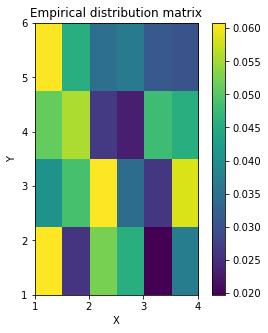

In [5]:
plt.figure(figsize=(5, 5))
c = plt.imshow(P_empirical, origin='lower', extent=(1, n, 1, m))
plt.colorbar(c)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Empirical distribution matrix")
plt.show()

#### Задание 2.2

Построение гистограммы составляющих вектора

A probabilities: [0.2413 0.2696 0.2501 0.239 ]


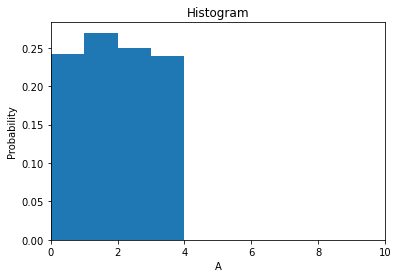

B probabilities: [0.2131 0.176  0.1746 0.1397 0.1253 0.1713]


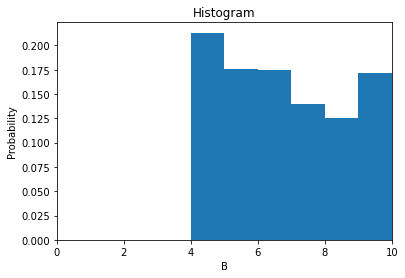

In [6]:
def plot_hist(x, weights, name):
    print(name, 'probabilities:', weights)
    plt.hist(x, bins=list(x) + [x[-1] + 1], weights=weights, align='mid', histtype='stepfilled')
    plt.xlim(0, n + m)
    plt.xlabel(name)
    plt.ylabel('Probability')
    plt.title('Histogram')
    plt.show()
    
plot_hist(A, P_empirical.sum(axis=1), 'A')
plot_hist(B, P_empirical.sum(axis=0), 'B')

#### Задание 2.3

Вычисление точечных, интервальных оценок.

In [7]:
from functools import partial


var = partial(np.var, ddof=1)
eval_on_trials = lambda f: list(map(f, map(lambda name: trials[name], sorted(trials.keys()))))
print('mean:', eval_on_trials(np.mean))
print('variance:', eval_on_trials(var))

mean: [1.4868, 6.302]
variance: [1.2105468146814682, 3.1201080108010797]


Возьмем уровень значимости alpha = 0.05

In [8]:
def get_confidence_interval_for_mean(samples, alpha=0.05):
    mean = np.mean(samples)
    variance = var(samples)
    diff = np.sqrt(variance / len(samples)) * sts.norm.ppf(1 - alpha / 2)
    return mean - diff, mean + diff 


def print_confidence_interval(interval, name, value_name):
    print(name, ':', interval[0], '<=', value_name, '<=', interval[1])


print('Confidence interval for mean (alpha=0.05):')
for name in ('a', 'b'):
    print_confidence_interval(get_confidence_interval_for_mean(trials[name]), name, 'mean')

Confidence interval for mean (alpha=0.05):
a : 1.4652355251881217 <= mean <= 1.508364474811878
b : 6.267379534319119 <= mean <= 6.33662046568088


In [9]:
def get_confidence_interval_for_variance(samples, alpha=0.05):
    n = len(samples) 
    numerator = (n - 1) * np.sqrt(var(samples))
    return (
        numerator / sts.chi2.ppf(1 - alpha / 2, n - 1),
        numerator / sts.chi2.ppf(alpha / 2, n - 1),
    )


print('Confidence interval for variance (alpha=0.95):')
for name in ('a', 'b'):
    print_confidence_interval(get_confidence_interval_for_variance(trials[name]), name, 'variance')

Confidence interval for variance (alpha=0.95):
a : 1.0703760175283734 <= variance <= 1.1313953041744993
b : 1.718424237258341 <= variance <= 1.816387027339386


#### Задание 2.4

Вычисление коэффициент корреляции

In [10]:
def get_correlation_coefficient(trials, names):
    means = eval_on_trials(np.mean)
    variances = eval_on_trials(var)
    return (trials['a'] - means[0]) @ (trials['b'] - means[1]) / len(trials['a'] - 1) / np.sqrt(variances[0] * variances[1])

get_correlation_coefficient(trials, ('a', 'b'))

-0.02676340120634631

### Задание 3

Проверить гипотезы о соответствии полученных оценок характеристик  случайной величины требуемым.

Проверим используя критерий хи-квадрат.

In [20]:
sts.chisquare(np.ravel(P_empirical), np.ravel(P))[1] >= 1 - 0.05

True